In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# **Q1**

# Q1.1

- I chose Linear Regression because Cook's Distance is mostly meant for OLS Linear Regression influence diagnostics and since the primary concern is outliers and not generalization.

- I chose Statsmodels OLS because it has built in influence diagnostics.


# Q1.2

In [66]:
df = pd.read_csv("usina_with_outliers.csv")

X = df[["AT", "V", "AP", "RH"]]
y = df["PE"]

X_ols = sm.add_constant(X)
ols = sm.OLS(y, X_ols).fit()

influence = ols.get_influence()
cooks_d = influence.cooks_distance[0]

n = len(df)
threshold = 4 / n

outlier_idx = np.where(cooks_d > threshold)[0]
print("n =", n)
print("threshold =", threshold)
print("# outliers =", len(outlier_idx))

df_clean = df.drop(index=outlier_idx).reset_index(drop=True)

df_clean.to_csv("usina.csv", index=False)

n = 9568
threshold = 0.0004180602006688963
# outliers = 120


# **Q2**

In [67]:
def eval_models(df, random_state=42):
    X = df[["AT","V","AP","RH"]].values
    y = df["PE"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=random_state
    )

    rows = []

    def add_row(name, lam, model):
        model.fit(X_train, y_train)
        ytr = model.predict(X_train)
        yte = model.predict(X_test)

        rows.append({
            "Model": name,
            "lambda": lam,
            "Train MSE": mean_squared_error(y_train, ytr),
            "Train MAE": mean_absolute_error(y_train, ytr),
            "Train R2": r2_score(y_train, ytr),
            "Test MSE": mean_squared_error(y_test, yte),
            "Test MAE": mean_absolute_error(y_test, yte),
            "Test R2": r2_score(y_test, yte),
        })

    add_row("Linear", None, LinearRegression())

    lambdas = [0.01, 0.1, 1, 10, 100]
    for lam in lambdas:
        add_row("Ridge", lam, Ridge(alpha=lam, random_state=random_state))
    for lam in lambdas:
        add_row("Lasso", lam, Lasso(alpha=lam, max_iter=100000, random_state=random_state))

    return pd.DataFrame(rows)

df_out = pd.read_csv("usina_with_outliers.csv")
df_clean = pd.read_csv("usina.csv")

res_out = eval_models(df_out)
res_clean = eval_models(df_clean)

print("WITH OUTLIERS")
print(res_out.sort_values("Test R2", ascending=False).head(3))

print("\nCLEANED")
print(res_clean.sort_values("Test R2", ascending=False).head(3))

WITH OUTLIERS
    Model  lambda   Train MSE  Train MAE  Train R2    Test MSE  Test MAE  \
0  Linear     NaN  123.384207   5.198679  0.650171  125.113389  5.052458   
1   Ridge    0.01  123.384207   5.198679  0.650171  125.113389  5.052458   
2   Ridge    0.10  123.384207   5.198680  0.650171  125.113392  5.052459   

    Test R2  
0  0.642574  
1  0.642574  
2  0.642574  

CLEANED
   Model  lambda  Train MSE  Train MAE  Train R2   Test MSE  Test MAE  \
7  Lasso     0.1  19.865263   3.596855  0.931367  20.392600  3.624890   
5  Ridge   100.0  19.864758   3.596742  0.931369  20.394626  3.624880   
4  Ridge    10.0  19.864672   3.596430  0.931369  20.396549  3.624783   

    Test R2  
7  0.930316  
5  0.930310  
4  0.930303  


- Outliers change test error; With outliers the Test R² = 0.64 and without outliers the Test R² = 0.93.
- The dataset without outliers shows better generalization.
- Ridge does not help in comparison to Linear, and Lasso helps at a small λ and gets worse at large λ, since it eventually underfits.

# **Q3**

# 3.1

- I chose this model because stamdard errors, p-values, t-stats, and confidence intervals were needed.
- I chose this library because it provides all of the necessary reliability evidence in the regression summary.
- No, I would keep all of the original units for interpretability.
- This is because significance-style reliability doesn't improve from scaling since scaling a predictor changes the coefficient and the standard error proportionally

# 3.2

In [71]:
df = pd.read_csv("usina.csv")

X = df[["AT", "V", "AP", "RH"]]
y = df["PE"]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

summary = pd.DataFrame({
    "coef": model.params,
    "t": model.tvalues,
    "p": model.pvalues
})

feat = summary.drop(index="const").copy()

most_reliable = feat["t"].abs().idxmax()
least_reliable = feat["t"].abs().idxmin()

print(feat)
print("\nMost reliable coefficient:", most_reliable)
print("Least reliable coefficient:", least_reliable)

        coef           t              p
AT -1.954640 -129.113036   0.000000e+00
V  -0.237885  -33.056481  7.527041e-227
AP  0.074638    7.894540   3.238569e-15
RH -0.148856  -36.897303  1.578009e-278

Most reliable coefficient: AT
Least reliable coefficient: AP


# **Q4**

# 4.1

- I chose linear regression because the coefficients provide a measure of feature importance.
- I chose Scikit-learn because it is good for scaling features and comparing coefficient magnitudes for feature importance.
- I would not scale since it's not necessary for comparing importance from standardized X coefficients.

# 4.2

In [69]:
df = pd.read_csv("usina.csv")
X = df[["AT","V","AP","RH"]].values
y = df["PE"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)

model = LinearRegression()
model.fit(X_train_s, y_train)

features = ["AT","V","AP","RH"]
coefs = model.coef_

importance = sorted(zip(features, np.abs(coefs)), key=lambda x: x[1], reverse=True)
print("Standardized coefficient magnitudes:")
for f, mag in importance:
    print(f, mag)

print("\nMost important:", importance[0][0])
print("Least important:", importance[-1][0])

Standardized coefficient magnitudes:
AT 14.637187846870638
V 2.979021853918676
RH 2.230954447750525
AP 0.4283724325698337

Most important: AT
Least important: AP


# **Q5**

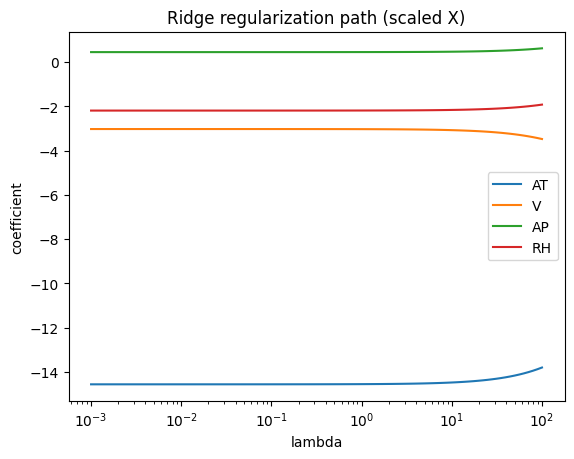

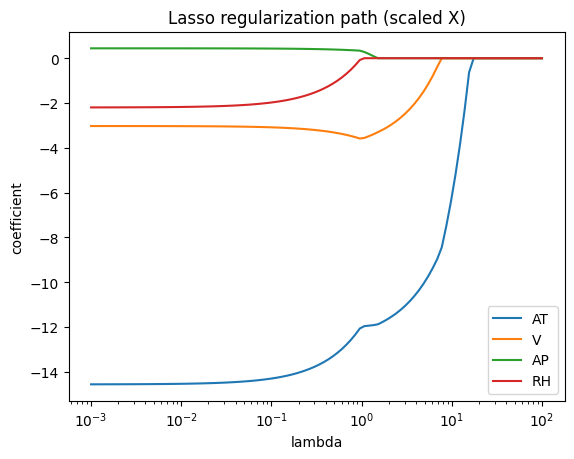

In [70]:
df = pd.read_csv("usina.csv")
X = df[["AT","V","AP","RH"]].values
y = df["PE"].values

scaler = StandardScaler()
X_s = scaler.fit_transform(X)

lambdas = np.logspace(-3, 2, 100)

features = ["AT","V","AP","RH"]
ridge_coefs = []
lasso_coefs = []

for lam in lambdas:
    r = Ridge(alpha=lam)
    r.fit(X_s, y)
    ridge_coefs.append(r.coef_)

    l = Lasso(alpha=lam, max_iter=200000)
    l.fit(X_s, y)
    lasso_coefs.append(l.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

plt.figure()
for j, f in enumerate(features):
    plt.plot(lambdas, ridge_coefs[:, j], label=f)
plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("coefficient")
plt.title("Ridge regularization path (scaled X)")
plt.legend()
plt.show()

plt.figure()
for j, f in enumerate(features):
    plt.plot(lambdas, lasso_coefs[:, j], label=f)
plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("coefficient")
plt.title("Lasso regularization path (scaled X)")
plt.legend()
plt.show()


- As λ increases in Ridge, coefficients shrink toward 0 but don't = 0. As λ increases in Lasso, coefficients shrink and become exactly 0.
- Ridge is better in multicollinearity because it keeps correlated features and shrinks estimates together.
- Lasso is better for feature selection because some coefficients will go exactly to zero.
